### To Do:
- change balance after buy (not wait until sell) without affecting fitness
### IDEAS:
### Observations
- higher pred accuracy increases profit
- 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [70]:
# Class for individuals of population. Individual is choosing entry-points, exit-points and position size based on time step price data. These actions are parameterized through "gene vector".
class individual:
    def __init__(self):
        # dna 0: price to take profit
        # dna 1: price to stop loss
        # dna 2: position size as fraction of balance
        # dna 3: buy if difference in price and predicted future price is larger than this
        self.dna = np.random.uniform(0,1,4)
        self.dna[1] = self.dna[1]*(-1)
        self.pos_price = 0
        self.pos_size = 0
        self.returns = 1
        
    def action(self, price, future_price, balance):
        if self.pos_size>0:
            return self.sell(price, balance)
        else:
            return self.buy(price, future_price, balance)
            
            
    def buy(self, price, future_price, balance):
        #self.balance -= self.pos_size*self.pos_price
        #print("action: buy    --   at: ", price, "  --   new balance: ", self.balance)
        #print(100*(future_price-price)/price, self.dna[3])
        if 100*(future_price-price)/price>self.dna[3]:
            self.pos_price = price
            self.pos_size = balance*self.dna[2]/self.pos_price
            return "buy", 0
        else:
            return "no pos", 0
        
    # sell if change % of position is larger than take profit dna[0] or smaller than stop loss dna[1]
    def sell(self, price, balance):
        change = 100*(price-self.pos_price)/(self.pos_price)
        pos_change = self.pos_size*price - self.pos_size*self.pos_price
        #print("% change: ", change, "  --   take profit: ", self.dna[0], "  --   stop loss: ", self.dna[1])
        if change>self.dna[0] or change<self.dna[1]:
            self.returns += pos_change
            self.pos_size = 0
            return "sell", pos_change
        else:
            return "hold", 0
        #print("action: sell   --   at: ", price, "  --   new balance: ", self.balance)
        
    def get_return(self):
        return self.returns
    
    def get_dna(self):
        return self.dna
    def set_dna(self, new_dna):
        self.dna = new_dna
        

In [74]:
# population comprised of individuals that simulates evolution
# size: number of individuals in population. is automatically rounded up to nearest even number 
# mutation_prob: probability of an individual gene mutation at each new generation
# mutation_str: strength of mutation; as addition of value from normal distribution with this std and mean 0
# generation_age: timesteps after which a new generation is build
class population:
    def __init__(self, size, gene_num=4, mutation_prob=0.1, mutation_str=0.01, generation_age=10):
        self.pop = []
        self.size = size + size%2
        self.gene_num = gene_num
        self.mutation_prob = mutation_prob
        self.mutation_str = mutation_str
        self.generation_age = generation_age
        self.time = 0
        self.balance = 1000000
        for ii in range(size):
            self.pop.append(individual())
            
    # population exists for one timestep. may god have mercy on their souls
    def exist(self, price, future_price):
        self.time += 1
        #print("timestep: ", self.time)
        gen_revenue = np.sum([p.get_return() for p in self.pop])
        if self.time%self.generation_age==0:
            self.newgen()
            #print("geneneration no.", self.time/self.generation_age)
            #for ii, ind in enumerate(self.pop):
                #print("individual: ", ii, "  --   dna: ", ind.get_dna())
                
        for ii, p in enumerate(self.pop):
            action, amount_change = p.action(price, future_price, self.balance)
            self.balance += amount_change
            ret = p.returns
            #print("individual: ", ii, "  --   action: ", action, "  --   change: ", amount_change)#, "  --   balance: ", balance)
        return gen_revenue
    
    # evaluates individuals based on returns
    def evaluate(self):
        fitness = []
        for p in self.pop:
            fitness.append(p.get_return())
        return np.array(fitness)
    
    # creates new iteration of population
    def newgen(self):
        survivors = self.roulette_select()
        children = self.crossover(survivors)
        new_pop = self.mutate(children)
        self.pop = new_pop
        
    # selects size/2 from population via roulette wheel selection
    def roulette_select(self):
        new_pop = []
        fitness = self.evaluate()
        total_fitness = fitness.sum()
        rel_fitness = fitness/total_fitness
        probs = np.array([np.sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))])
        spins = np.random.uniform(0,1,round(self.size/2))
        for n in range(round(self.size/2)):
            spin = np.random.uniform(0,1)
            for ii, ind in enumerate(self.pop):
                if spin <= probs[ii]:
                    new_pop.append(ind)
        return new_pop
                    
    # generates new individuals via crossover
    def crossover(self, survivors):
        new_pop = []
        for ii in range(self.size):
            child = individual()
            parents = np.random.randint(0,round(self.size/2), 2)
            parent1 = survivors[parents[0]]
            parent2 = survivors[parents[1]]
            dna1 = parent1.get_dna()
            dna2 = parent2.get_dna()
            crossover_point = np.random.randint(1,len(dna1))
            new_dna = np.concatenate((dna1[:crossover_point], dna2[crossover_point:]))
            child.set_dna(new_dna)
            new_pop.append(child)
        return new_pop
            
    # mutates new generation by adding gaussian distributed noise to some random genes
    def mutate(self, new_pop):
        for ind in new_pop:
            dna = ind.get_dna()
            mutation = np.random.uniform(-self.mutation_str, self.mutation_str, self.gene_num)
            gene_select = np.random.binomial(1,self.mutation_prob,self.gene_num)
            dna += mutation*gene_select
            ind.set_dna(dna)
        return new_pop
    
    def get_pop(self):
        return self.pop
        

In [75]:
g = 0.01
A = np.random.uniform(-g,g,5)
print(A)

[-0.00152277 -0.0021982  -0.00419043 -0.00038961  0.00115169]


prediction_acc:  0.01
[ 0.40540106 -1.15674855  1.05283082  0.00382215]
[ 0.40099607 -1.16925836  1.04488199  0.0032501 ]
[ 0.41383109 -1.15155151  1.05619981 -0.00642381]
[ 0.41981431 -1.15280891  1.0597118  -0.00670668]
[ 4.19555767e-01 -1.14808361e+00  1.04231927e+00  5.93214360e-04]
[ 0.42095438 -1.1627489   1.05880888  0.00382543]
[ 0.41733519 -1.15167318  1.04391141 -0.00670668]
[ 4.13831089e-01 -1.15460640e+00  1.05283082e+00  5.93214360e-04]
[ 0.41460157 -1.16529744  1.02814824 -0.00901178]
[ 0.41076591 -1.14830071  1.05039008  0.0101239 ]


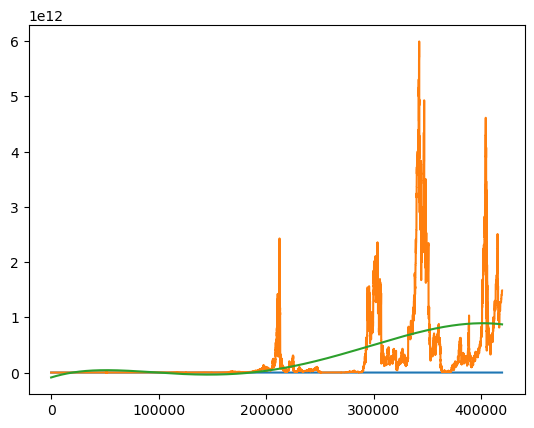

prediction_acc:  0.02
[ 1.32639472 -0.48714517  0.762929   -0.07389964]
[ 1.33291427 -0.49336676  0.75947078 -0.07156437]
[ 1.29328751 -0.49404177  0.75427884 -0.08019752]
[ 1.3271787  -0.49121945  0.76688761 -0.06885339]
[ 1.29328751 -0.48700106  0.77349032 -0.05076884]
[ 1.32639472 -0.49499168  0.76688761 -0.05419075]
[ 1.32639472 -0.48714517  0.77671638 -0.07156437]
[ 1.31723502 -0.47661708  0.76326333 -0.07911884]
[ 1.32611785 -0.48785483  0.76229341 -0.06961813]
[ 1.3238781  -0.47661708  0.75348498 -0.08000447]


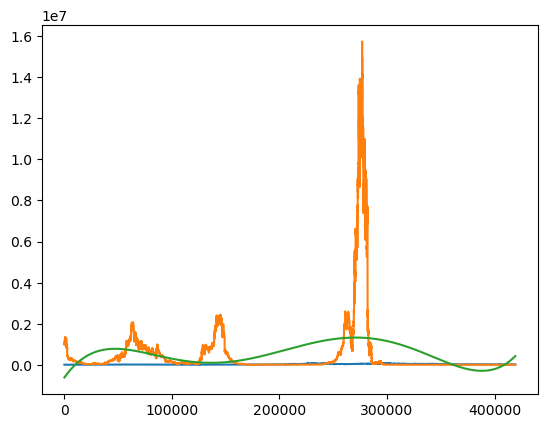

prediction_acc:  0.03
[0.30526218 0.07712996 0.94708082 0.28330151]
[0.31200308 0.06394862 0.92039446 0.28107061]
[0.30966989 0.07009408 0.95340907 0.27799071]
[0.30966989 0.08138745 0.95858403 0.27910548]
[0.31768774 0.06719397 0.92039446 0.28107061]
[0.30484881 0.0714741  0.95858403 0.28219457]
[0.30982431 0.06719397 0.95656894 0.27799071]
[0.31215223 0.07712996 0.94708082 0.28330151]
[0.31117029 0.06719397 0.92039446 0.27799071]
[0.30122518 0.07347529 0.96482513 0.2908868 ]


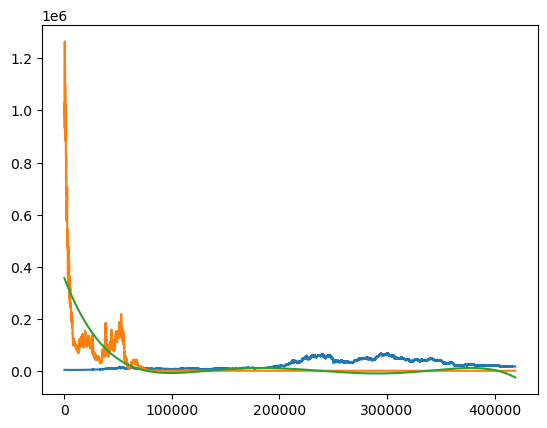

prediction_acc:  0.04
[ 0.17246204 -0.11735618  1.07423233 -0.28485775]
[ 0.19126923 -0.09727621  1.08395791 -0.28169761]
[ 0.1901089  -0.10409867  1.06375359 -0.31508136]
[ 0.18260644 -0.12474413  1.05048351 -0.29982877]
[ 0.17263887 -0.11179538  1.08483419 -0.29051943]
[ 0.18109368 -0.11717753  1.06860641 -0.30659341]
[ 0.18058271 -0.11735618  1.07438015 -0.28439729]
[ 0.17497781 -0.09986724  1.06375359 -0.28178322]
[ 0.18611442 -0.09460985  1.07975045 -0.29982877]
[ 0.19126923 -0.10409867  1.07098409 -0.28538881]


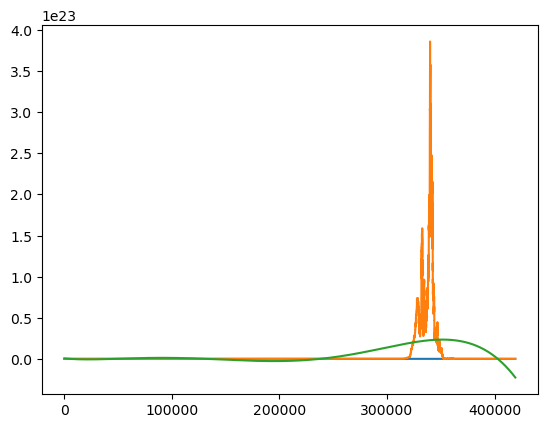

prediction_acc:  0.05
[ 1.06704501 -0.11755723  1.12585088 -0.23739273]
[ 1.06318236 -0.12560089  1.12272369 -0.23348343]
[ 1.07091608 -0.12560089  1.10887379 -0.22375189]
[ 1.06738505 -0.1068253   1.11859589 -0.21766377]
[ 1.06318236 -0.11463886  1.13296272 -0.22173803]
[ 1.06318236 -0.11463886  1.13296272 -0.22173803]
[ 1.06333888 -0.12237766  1.12488991 -0.22748528]
[ 1.06333888 -0.1181754   1.13296272 -0.221546  ]
[ 1.06710774 -0.11463886  1.14347865 -0.22225086]
[ 1.06704501 -0.11607338  1.13459524 -0.22225086]


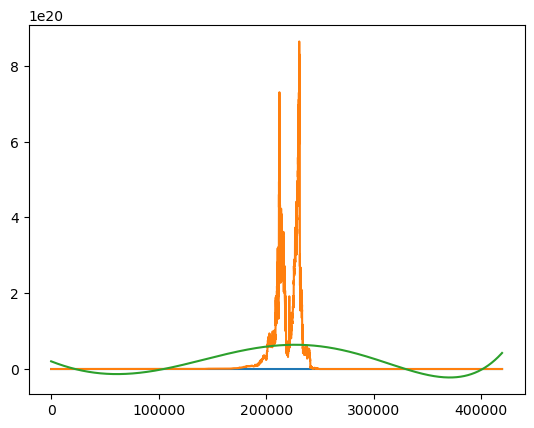

prediction_acc:  0.060000000000000005
[ 0.29057394 -0.18037973  0.79779884 -0.07863558]
[ 0.2691392  -0.17577201  0.79883645 -0.11401413]
[ 0.28880835 -0.18896438  0.79242315 -0.08332517]
[ 0.28839754 -0.19895834  0.80087682 -0.0885612 ]
[ 0.26430736 -0.18896438  0.79952518 -0.0885612 ]
[ 0.27083818 -0.18322401  0.79779884 -0.0885612 ]
[ 0.29093789 -0.19454068  0.80492255 -0.11562969]
[ 0.25845009 -0.1927761   0.80126989 -0.11335333]
[ 0.26430736 -0.17760483  0.80641999 -0.1349447 ]
[ 0.29162188 -0.18896438  0.80087682 -0.08434588]


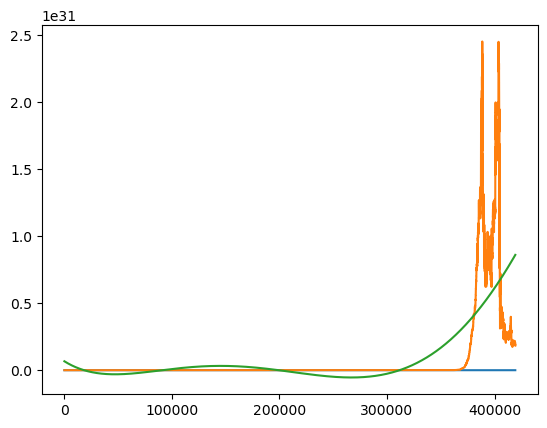

prediction_acc:  0.06999999999999999
[ 0.56072423 -0.85477777  0.85759747 -0.01479543]
[ 0.53739267 -0.87816096  0.85157897  0.01554111]
[ 0.5508759  -0.85606409  0.85759747 -0.0050334 ]
[ 0.54485012 -0.85617334  0.85339714  0.01321125]
[ 0.5508759  -0.87197975  0.85339714  0.00894545]
[ 0.54485012 -0.85706225  0.85977247  0.01621312]
[ 0.55825487 -0.85606409  0.85759747 -0.01748837]
[ 0.54485012 -0.85955587  0.85339714 -0.01922073]
[ 0.54792621 -0.8631818   0.86458723  0.01084724]
[ 0.5508759  -0.87533071  0.85759747 -0.00824037]


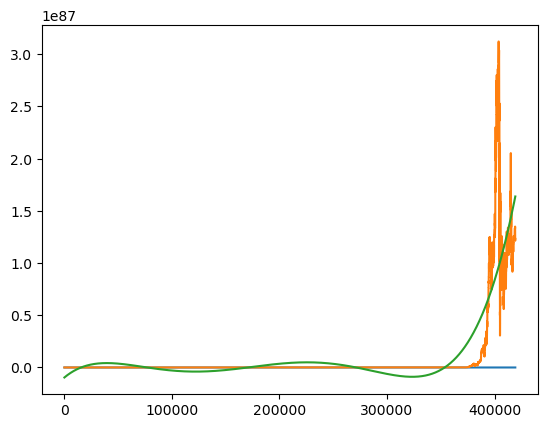

prediction_acc:  0.08
[ 0.83501334 -0.26393549  0.40917776  0.09291163]
[ 0.83407517 -0.25614846  0.40367486  0.09531528]
[ 0.8299911  -0.26743307  0.40573494  0.09245342]
[ 0.84342113 -0.26234201  0.38675397  0.09293097]
[ 0.83147754 -0.26117923  0.41230231  0.09291163]
[ 0.8328057  -0.25869799  0.38675397  0.09291163]
[ 0.8299911  -0.26544763  0.38675397  0.09291163]
[ 0.82180459 -0.26296217  0.39657591  0.0988947 ]
[ 0.84141938 -0.26393549  0.40724076  0.09865212]
[ 0.82705073 -0.25489602  0.39531583  0.09085517]


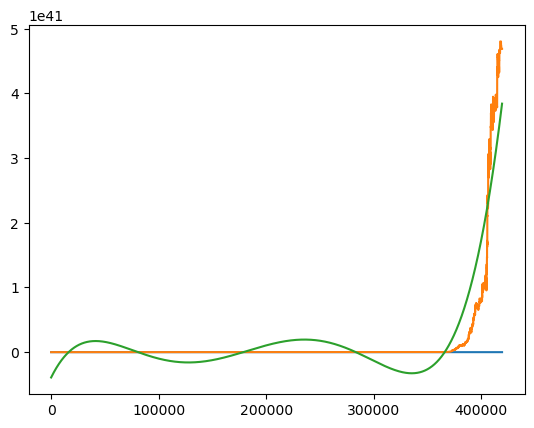

prediction_acc:  0.09


KeyboardInterrupt: 

In [83]:
PATH = "data/5m_price_data___start_2019-1-1_stop_2023-1-1.npy"
data = np.load(PATH)
size = 10
mutation_prob = 0.5
mutation_str = 0.01
generation_age = 100
prediction_acc = 0.1
length = len(data)
for prediction_acc in np.arange(0.01,0.1,0.01):
    print("prediction_acc: ", prediction_acc)
    pop = population(size, mutation_prob=mutation_prob, mutation_str=mutation_str, generation_age=generation_age)
    price_data_future = data[5:]
    selection = np.random.binomial(1,prediction_acc,len(price_data_future))
    price_prediction = selection*price_data_future + (1-selection)*data[:-5]
    balances = []
    for tt, price in enumerate(data[:length-5]):
        future_price = price_prediction[tt] + np.random.normal(0,5)
        revenue = pop.exist(price, future_price)
        #print(revenue)
        balances.append(pop.balance)

    for i in range(10):
        print(pop.get_pop()[i].get_dna())
    #plt.plot(balances)
    ##plt.show()

    #rev_sum = np.cumsum(revenues)
    x = np.arange(length-5)
    p = np.polyfit(x,balances,5)
    y = [np.polyval(p, i) for i in x]
    #print(rev_sum)
    plt.plot(x, data[:-5], x, balances, x, y)
    plt.show()

In [ ]:
print(balances[-200000:-100000])

In [ ]:
change = []
for ii in range(length-5):
    change.append((price_data[ii+5] - price_data[ii])/price_data[ii])
plt.plot(change)
print(np.mean(change))

In [ ]:
for i in np.arange(0,1,9):
    print(i)

In [ ]:
dna1 = np.random.randint(0,100,10)
dna2 = np.random.randint(0,100,10)
print(dna1)
print(dna2)
for i in range(100):
    cp = np.random.randint(1,len(dna1))
    print(cp)
    child = np.concatenate((dna1[:cp], dna2[cp:]))
    print(child)
    print("\n")

In [ ]:
A = np.random.binomial(1, 0.1, 8)
print(A)